In [100]:
#Import all the necessary classes for this project
import pandas as pd
import numpy as np
import matplotlib 
import math
from matplotlib import pylab as plt
import seaborn as sns
from sklearn.model_selection import PredefinedSplit
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
import shap
import pickle

In [12]:
#Upload the different dataframes. 
df_prices=pd.read_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/prices.csv')
df_securities=pd.read_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/securities.csv')
df_fundamentals=pd.read_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/fundamentals.csv')

#printing datatypes in df_prices of the two categories I later have to merge
print("Data types in df_prices:")
print("symbol:", df_prices["symbol"].dtype)
print("date:", df_prices["date"].dtype)

print("symbol:", df_securities["Ticker symbol"].dtype)

#printing datatypes in df_fundamentals of the two categories I later have to merge
print("\nData types in df_fundamentals:")
print("Ticker Symbol:", df_fundamentals["Ticker Symbol"].dtype)
print("Period Ending:", df_fundamentals["Period Ending"].dtype)

Data types in df_prices:
symbol: object
date: object
symbol: object

Data types in df_fundamentals:
Ticker Symbol: object
Period Ending: object


In [13]:
#Printing the shape of the prices dataframe before modification
print(df_prices.shape)

#drop not necessary features
df_prices = df_prices.drop(columns=['open', 'low', 'high'])

#rename columns to then use in a join statement. 
df_prices = df_prices.rename(columns={"symbol": "Company", "date": "Date"})

#Convert to Date format the date feature
df_prices['Date'] = df_prices['Date'].astype(str).str[:10]
df_prices['Date'] = pd.to_datetime(df_prices['Date'], format='%Y-%m-%d')

#lag prices, in order to have more feastures to later use to predict the current price. 
#Useful as, as seen later, prices  are highly autocorrelated
df_prices['Price_Previous_Day'] = df_prices.groupby('Company')['close'].shift(1)
df_prices['Price_Two_Days_Ago'] = df_prices.groupby('Company')['close'].shift(2)
df_prices['Price_Three_Days_Ago'] = df_prices.groupby('Company')['close'].shift(3)
df_prices['Price_Four_Days_Ago'] = df_prices.groupby('Company')['close'].shift(4)
df_prices['Price_Five_Days_Ago'] = df_prices.groupby('Company')['close'].shift(5)
print(df_prices.shape)
df_prices.head()

(851264, 7)
(851264, 9)


,Date,Company,close,volume,Price_Previous_Day,Price_Two_Days_Ago,Price_Three_Days_Ago,Price_Four_Days_Ago,Price_Five_Days_Ago
0,2016-01-05,WLTW,125.839996,2163600.0,NaN,NaN,NaN,NaN,NaN
1,2016-01-06,WLTW,119.980003,2386400.0,125.839996,NaN,NaN,NaN,NaN
2,2016-01-07,WLTW,114.949997,2489500.0,119.980003,125.839996,NaN,NaN,NaN
3,2016-01-08,WLTW,116.620003,2006300.0,114.949997,119.980003,125.839996,NaN,NaN
4,2016-01-11,WLTW,114.970001,1408600.0,116.620003,114.949997,119.980003,125.839996,NaN


In [14]:
#Must merge the information with that of the previous quarter as a company will not have access to the 
#information for the end of the quarter it is operating in. 

df_prices['Date'] = pd.to_datetime(df_prices['Date'])

df_prices['Year'] = df_prices['Date'].dt.year
df_prices['Month'] = df_prices['Date'].dt.month

In [15]:
#find the quarter for each row by using the date

for index, row in df_prices.iterrows():
    if row['Month'] <= 3:
        df_prices.loc[index, 'Quarter'] = 1
    elif row['Month'] > 3 and row['Month'] <= 6:
        df_prices.loc[index, 'Quarter'] = 2
    elif row['Month'] >= 7 and row['Month'] <= 9:
        df_prices.loc[index, 'Quarter'] = 3
    else:
        df_prices.loc[index, 'Quarter'] = 4

In [16]:
#find the year of the quarter for each row by using the date
def get_previous_quarter(row):
    if row['Quarter'] == 1:
        return 4, row['Year'] - 1  #If it's Q1, return Q4 of the previous year
    else:
        return row['Quarter'] - 1, row['Year']  # Otherwise, just the previous quarter of the same year

df_prices['Previous_Quarter'], df_prices['Year_previous_Quarter'] = zip(*df_prices.apply(get_previous_quarter, 
                                                                                         axis=1))

In [17]:
#drop the now unnecessary month column
df_prices=df_prices.drop(columns=['Month'])
print(df_prices.iloc[1:len(df_prices):100000])
print(df_prices.dtypes)

             Date Company       close      volume  Price_Previous_Day  \
1      2016-01-06    WLTW  119.980003   2386400.0          125.839996   
100001 2010-11-04     TEL   32.700001   1650000.0           32.119999   
200001 2011-09-09     MYL   19.360001   8049800.0           19.490000   
300001 2012-07-16     GPC   61.150002    996600.0           61.290001   
400001 2013-05-17     GPN   47.380001   1534800.0           46.759998   
500001 2014-03-12     AFL   64.889999   1006600.0           64.949997   
600001 2014-12-31     BCR  166.619995    378700.0          168.660004   
700001 2015-10-20     APD  137.349998    888500.0          138.029994   
800001 2016-08-05    INTC   34.980000  20046200.0           34.580002   

        Price_Two_Days_Ago  Price_Three_Days_Ago  Price_Four_Days_Ago  \
1                      NaN                   NaN                  NaN   
100001           31.770000             31.670000            31.680000   
200001           19.850000             19.270000  

In [18]:
#Save the prices dataframe that has just been modified
df_prices.to_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/prices_Modification.csv', index=False)

In [19]:
#Now we look at the fundamentals dataframe. 

In [20]:
#rename columns to later use in join statement
df_fundamentals=df_fundamentals.rename(columns={'Period Ending': 'Date', 'Ticker Symbol': 'Company'})

#Change date into date format
df_fundamentals['Date'] = pd.to_datetime(df_fundamentals['Date'], format='%Y-%m')

#Create new columns containg Year and Month 
df_fundamentals['Year'] = df_fundamentals['Date'].dt.year
df_fundamentals['Month'] = df_fundamentals['Date'].dt.month

In [21]:
#Find the quarter in which the fundamentals operate to then use when we merge this file with prices.
for index, row in df_fundamentals.iterrows():
    if row['Month'] <= 3:
        df_fundamentals.loc[index, 'Quarter'] = 1
    elif row['Month'] > 3 and row['Month'] <= 6:
        df_fundamentals.loc[index, 'Quarter'] = 2
    elif row['Month'] >= 7 and row['Month'] <= 9:
        df_fundamentals.loc[index, 'Quarter'] = 3
    else:
        df_fundamentals.loc[index, 'Quarter'] = 4

In [22]:
#Drop the unnecessary columns in the funamentals database
df_fundamentals=df_fundamentals.drop(columns=['Month','Date','Unnamed: 0','Deferred Liability Charges'])

#Printing shape and size
print(df_fundamentals.shape)
print(df_fundamentals.dtypes)

(1781, 78)
Company                          object
Accounts Payable                float64
Accounts Receivable             float64
Add'l income/expense items      float64
After Tax ROE                   float64
                                 ...   
For Year                        float64
Earnings Per Share              float64
Estimated Shares Outstanding    float64
Year                              int64
Quarter                         float64
Length: 78, dtype: object


In [23]:
#Save the fundamentals database with the new features later used for merging. 
df_fundamentals.to_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/fundamentals_Modification.csv', index=False)

In [24]:
#We now upload the two modified dataframes we want to merge of fundamentals and prices. 
df_fundamentals=pd.read_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/fundamentals_Modification.csv')
df_prices=pd.read_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/prices_Modification.csv')

In [25]:
#To merge the two dataframes, we have to assign the fundamentals of the previous quarter to each closing price. 
#Merge the datasets based on company and by assigning the fundamentals' values of the previous quarter
#to each tuple in the prices dataframe. 

df = pd.merge(df_prices, df_fundamentals,  how='right', 
                     left_on=['Company','Year_previous_Quarter','Previous_Quarter'], 
                     right_on = ['Company','Year','Quarter'])

#Dropduplicate columns
df=df.drop(columns=['Year_y', 'Quarter_y'])
df = df.rename(columns={"Year_x": "Year", "Quarter_x": "Quarter"})

pd.set_option('display.max_rows', None)
print(df.dtypes)
print(df.shape)

Date                                                    object
Company                                                 object
close                                                  float64
volume                                                 float64
Price_Previous_Day                                     float64
Price_Two_Days_Ago                                     float64
Price_Three_Days_Ago                                   float64
Price_Four_Days_Ago                                    float64
Price_Five_Days_Ago                                    float64
Year                                                   float64
Quarter                                                float64
Previous_Quarter                                       float64
Year_previous_Quarter                                  float64
Accounts Payable                                       float64
Accounts Receivable                                    float64
Add'l income/expense items                             

In [26]:
#Save the new merged dataframe between the prices and the fundamentals. We now have a data file that contains
#financial metrics as well as past prices and our tarhet variable
df.to_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/pricesMergeFundamentals.csv', index=False)

In [27]:
df=pd.read_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/pricesMergeFundamentals.csv')


#Rename the columns used in the later join statement
df_securities=df_securities.rename(columns={"Ticker symbol": "Company"})

#Merge the databases but only add the GICS Sector feature to the new dataframe. We merge them based on the 
#stock ticker name which has now been renamed to 'Company'
df = pd.merge(df, df_securities[['Company', 'GICS Sector']], on='Company', how='left')

print(df.shape)
print(df.dtypes)

(101388, 89)
Date                                                    object
Company                                                 object
close                                                  float64
volume                                                 float64
Price_Previous_Day                                     float64
Price_Two_Days_Ago                                     float64
Price_Three_Days_Ago                                   float64
Price_Four_Days_Ago                                    float64
Price_Five_Days_Ago                                    float64
Year                                                   float64
Quarter                                                float64
Previous_Quarter                                       float64
Year_previous_Quarter                                  float64
Accounts Payable                                       float64
Accounts Receivable                                    float64
Add'l income/expense items                

In [28]:
print(df.shape)

#Drop unnecessary columns in new merged dataframe
df=df.drop(columns=['Previous_Quarter','Year_previous_Quarter'] )
print(df.shape)

(101388, 89)
(101388, 87)


In [29]:
#Find the fraction of data which is missing in the features, and average amount of rows with missing values.  

print('data dimensions:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]

print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (101388, 87)
fraction of missing values in features:
Date                            0.001332
close                           0.001332
volume                          0.001332
Price_Previous_Day              0.001440
Price_Two_Days_Ago              0.001549
Price_Three_Days_Ago            0.001657
Price_Four_Days_Ago             0.001765
Price_Five_Days_Ago             0.001874
Year                            0.001332
Quarter                         0.001332
Cash Ratio                      0.166538
Current Ratio                   0.166538
Quick Ratio                     0.166538
For Year                        0.034610
Earnings Per Share              0.060303
Estimated Shares Outstanding    0.060303
dtype: float64
fraction of points with missing values: 0.21854657355900106


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


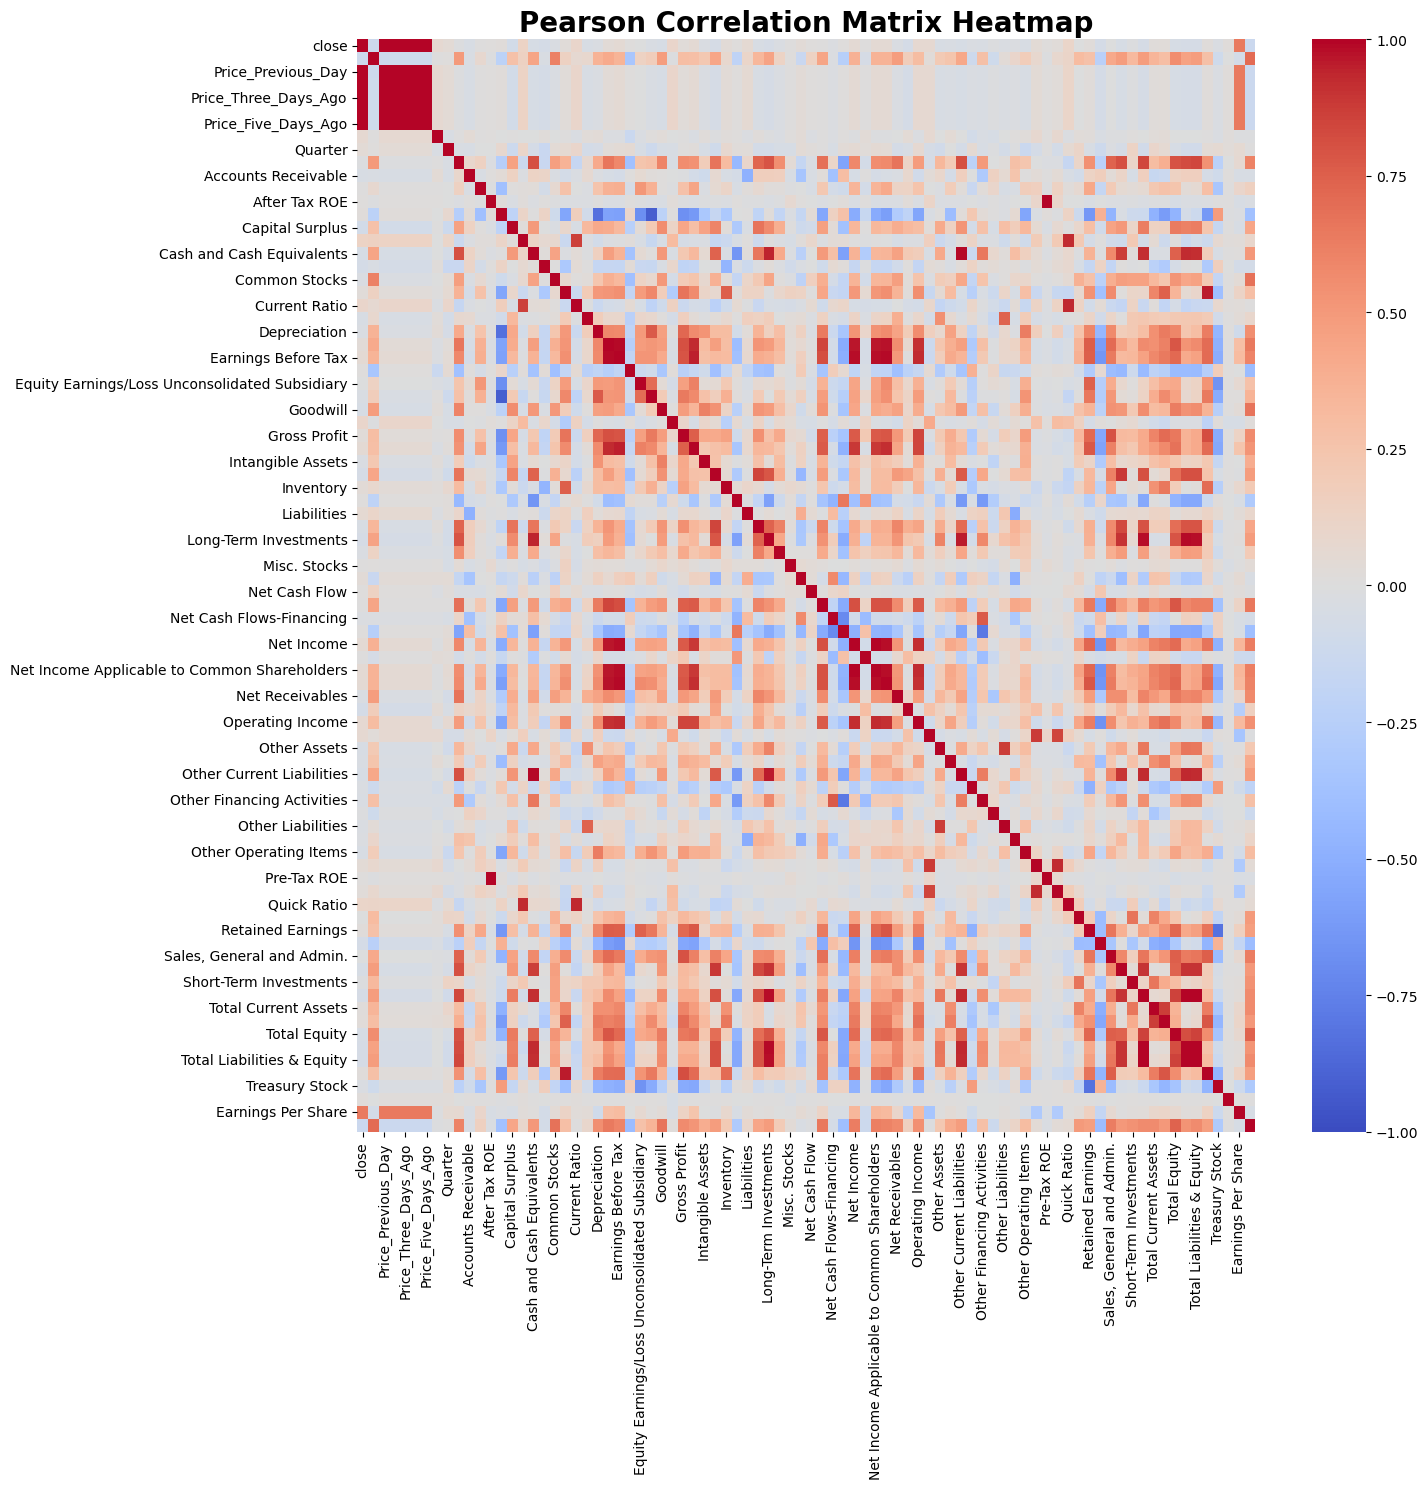

In [30]:
#Plot Pearson Correlation Matrix to see strongly correlated features. 
Pearson_correlation_matrix=df.corr(method='pearson')

plt.figure(figsize=(15, 15))
sns.heatmap(Pearson_correlation_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Pearson Correlation Matrix Heatmap",size=20, weight='bold')
plt.tight_layout()
plt.savefig('/Users/stefano/Desktop/DATA1030/FinalProject/Figures/Pearson_Matrix.png', dpi=300)
plt.show()

In [31]:
#Find how atrongly correlated some of the variables are and drop the variables with a very high correlation 
#to speed the later convergence of model.

corr_quick_cash = Pearson_correlation_matrix.loc["Quick Ratio", "Cash Ratio"]
corr_quick_current= Pearson_correlation_matrix.loc["Quick Ratio", "Current Ratio"]
corr_assets_liabilities = Pearson_correlation_matrix.loc["Total Assets", "Total Liabilities"]
corr_EPS_ESO= Pearson_correlation_matrix.loc["Earnings Per Share", "Estimated Shares Outstanding"]

print(f"Correlation between Quick Ratio and Cash Ratio: {corr_quick_cash}")
print(f"Correlation between Quick Ratio and Current Ratio: {corr_quick_current}")
print(f"Correlation between Total Assets and Total Liabilities: {corr_assets_liabilities}")
print(f"Correlation between Earnings Per Share and Estimated Shares Outstanding : {corr_EPS_ESO}")

#drop those with a very high correlation, mainly above 90s. 

Correlation between Quick Ratio and Cash Ratio: 0.9292941808136359
Correlation between Quick Ratio and Current Ratio: 0.9323843423335312
Correlation between Total Assets and Total Liabilities: 0.9973698846443441
Correlation between Earnings Per Share and Estimated Shares Outstanding : -0.04975937192148686


In [32]:
#Cannot drop EPS and Estimated Shares Outstanding and justify it by keeping either of the features 
#as the two features barealy have any correlation

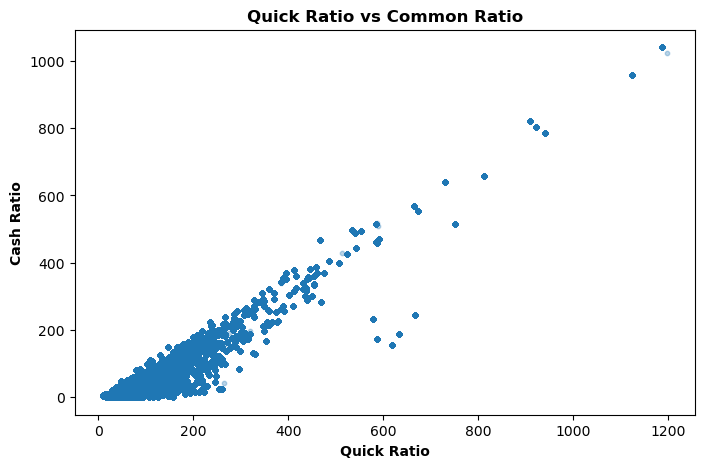

In [33]:
#Plotting some highly correlated variables to show the correlation between them. 
df.plot.scatter('Quick Ratio','Cash Ratio',figsize=(8,5),alpha=0.3,s=10)
plt.title('Quick Ratio vs Common Ratio',weight='bold') 
plt.xlabel('Quick Ratio',weight='bold')
plt.ylabel('Cash Ratio',weight='bold')
plt.savefig('/Users/stefano/Desktop/DATA1030/FinalProject/Figures/QuickvsCommonTable.png', dpi=300)
plt.show()

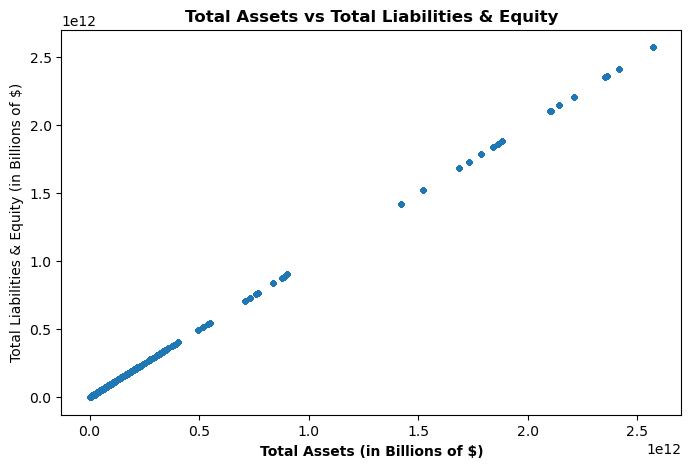

In [34]:
#Ploting Total Assets vs Total Equity and Total Liabilities as they are strongly correlated
df.plot.scatter('Total Assets','Total Liabilities & Equity',figsize=(8,5),alpha=0.3,s=10)
plt.title('Total Assets vs Total Liabilities & Equity', weight='bold',) 
plt.xlabel('Total Assets (in Billions of $)',weight='bold')
plt.ylabel('Total Liabilities & Equity (in Billions of $)')
plt.savefig('/Users/stefano/Desktop/DATA1030/FinalProject/Figures/AssetsvsLiabilities.png', dpi=300)
plt.show()

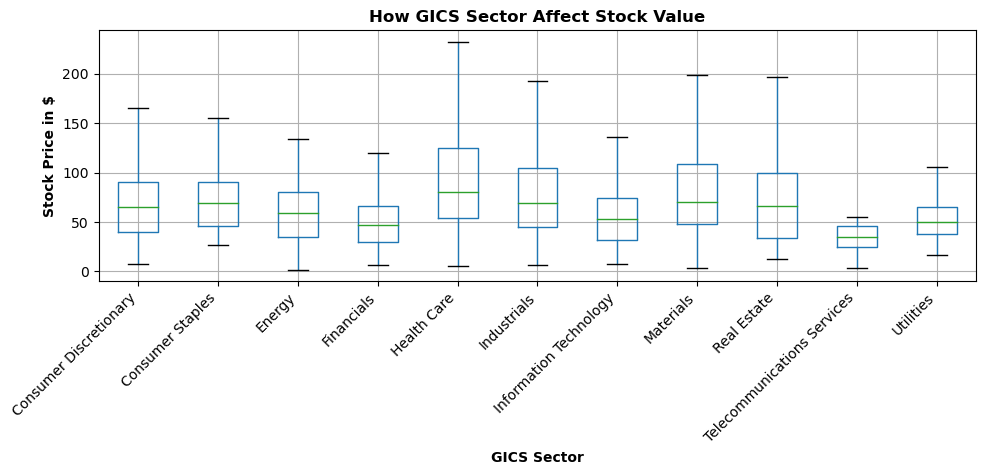

In [35]:
#Plotting our prices per sector on a boxplot. 
df[['GICS Sector','close']].boxplot(by='GICS Sector',figsize=(10,5),showfliers=False)
plt.title('How GICS Sector Affect Stock Value',weight='bold')
plt.xlabel('GICS Sector',weight='bold')
plt.ylabel('Stock Price in $',weight='bold')
plt.suptitle('')
caption = ""
plt.figtext(0.2,-0.05, caption, fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
ax = plt.gca()
plt.tight_layout()
plt.savefig('/Users/stefano/Desktop/DATA1030/FinalProject/Figures/SectorPrices.png', dpi=300)
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


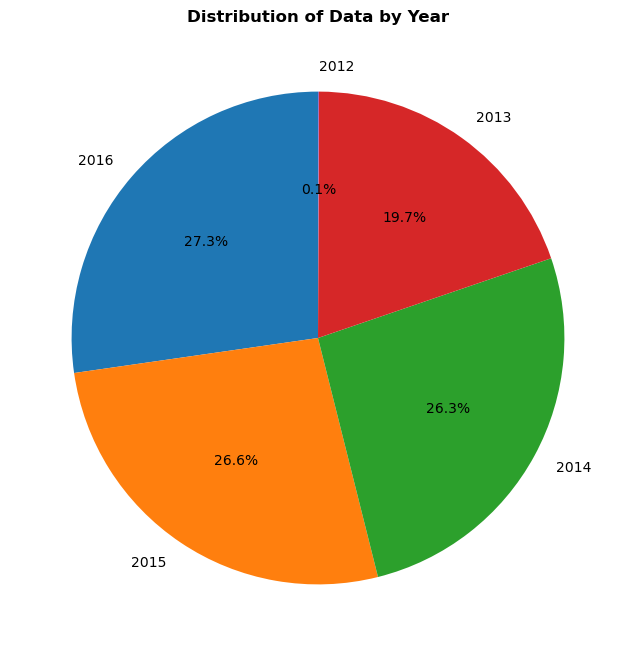

In [36]:
#Creating a piechart to show the distribution of the data by the year.

#Drop information where Year is not avaiable, as it will not be used in the models
df_piechart = df.dropna(subset=['Year'])
df_piechart['Year'] = df_piechart['Year'].astype(int)

year_counts = df_piechart['Year'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(year_counts, labels=year_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Data by Year', weight='bold')
plt.savefig('/Users/stefano/Desktop/DATA1030/FinalProject/Figures/DataDistributionbyYear.png', dpi=300)
plt.show()

In [37]:
#We can see the tuples we have are mainly spread out over 4 years, between 2013-2016.
#The data is split between these 5 years, with 
#only 0.1% of points being part of the 2012 group. Most of the data is contained in the 2016 year and is mainly
#split between 4 years of 2013-2016.

In [38]:
#Remove unnecessary features or features that are already highly correlated with others from the dataset.
df=df.drop(columns=['For Year', 'Cash Ratio', 'Current Ratio','Year', 'Quarter'])

In [39]:
#Drop rows without target variable or rows not containing lagged feature of target variable. 
df = df.dropna(subset=['close', 'Price_Previous_Day','Price_Two_Days_Ago','Price_Three_Days_Ago','Price_Four_Days_Ago' ,'Price_Five_Days_Ago'])

In [40]:
#Control which features still have missing values. 
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values in features:
Quick Ratio                     0.166436
Earnings Per Share              0.059112
Estimated Shares Outstanding    0.059112
dtype: float64


In [41]:
#Save our new database after dropping the features
df.to_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/MVDatabase.csv', index=False)

In [42]:
df=pd.read_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/MVDatabase.csv')

In [43]:
#Need to fill missing data before we can run an algorithm.
#We use linear regression Imputation to determine other values.  
#Can be used as the financial metrics are linearly related to each other

In [44]:
#Separate the columns I want to retain the same and do not want to be used for imputation as not numerical. 
date_column = df['Date']
company_column = df['Company']
gics_column=df['GICS Sector']

#Drop these columns from the DataFrame for imputation
df_for_imputation = df.drop(['Date', 'Company','GICS Sector'], axis=1)

#Initialize the IterativeImputer
imputer = IterativeImputer(estimator = LinearRegression(), random_state=42, verbose=2)

#Impute the remaining data
imputed_data = imputer.fit_transform(df_for_imputation)

#Create a DataFrame from the imputed data
df_imputed = pd.DataFrame(imputed_data, columns=df_for_imputation.columns)

#Reattach the date and company columns to the imputed DataFrame
df_imputed['Date'] = date_column
df_imputed['Company'] = company_column
df_imputed['GICS Sector']=gics_column

df=df_imputed

[IterativeImputer] Completing matrix with shape (101198, 79)
[IterativeImputer] Ending imputation round 1/10, elapsed time 21.26
[IterativeImputer] Change: 441556353862241.2, scaled tolerance: 2572274000.0 
[IterativeImputer] Ending imputation round 2/10, elapsed time 42.89
[IterativeImputer] Change: 433694239350921.0, scaled tolerance: 2572274000.0 
[IterativeImputer] Ending imputation round 3/10, elapsed time 64.61
[IterativeImputer] Change: 493859544530863.6, scaled tolerance: 2572274000.0 
[IterativeImputer] Ending imputation round 4/10, elapsed time 85.44
[IterativeImputer] Change: 453537635065725.4, scaled tolerance: 2572274000.0 
[IterativeImputer] Ending imputation round 5/10, elapsed time 105.64
[IterativeImputer] Change: 83346878257549.44, scaled tolerance: 2572274000.0 
[IterativeImputer] Ending imputation round 6/10, elapsed time 125.95
[IterativeImputer] Change: 227444320656426.0, scaled tolerance: 2572274000.0 
[IterativeImputer] Ending imputation round 7/10, elapsed time

[IterativeImputer] Early stopping criterion not reached.


In [45]:
#We check for any missing values and we see that we have now no missing values.
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values in features:
Series([], dtype: float64)


In [46]:
#save the database after the imputation
df.to_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/FinalDatabase.csv', index=False)

In [47]:
df=pd.read_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/FinalDatabase.csv')

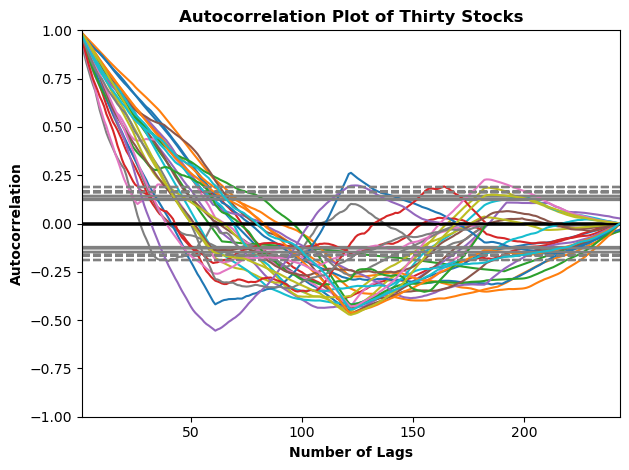

In [48]:
#Plotting the autocorrelation of 30 stocks to show how strongly the prices are autocorrelated
#with previous prices, showing a need to use previous prices for an accurate orediction of the current one. 
companies = df['Company'].unique()[:30]

#For each of the first 30 companies we calculate the correlation with its price and different lagged prices
for c in companies:
    
    #find and plot the autocorrelation with the previous prices. 
    hc = df.loc[df['Company']==c,df.columns=='close']
    pd.plotting.autocorrelation_plot(hc)

#label and show the plot
plt.title("Autocorrelation Plot of Thirty Stocks", weight='bold')
plt.tight_layout()
plt.xlabel('Number of Lags',weight='bold')
plt.ylabel('Autocorrelation',weight='bold')
plt.savefig('/Users/stefano/Desktop/DATA1030/FinalProject/Figures/AutocorrelationPlot.png', dpi=300)
plt.show()

In [49]:
#As we can see, as time goes on the correlation between the stock prices decreases more
#and more. 
#The correlation is initially positive. 
#There are stocks that appear to follow more seasonal patterns, 
#possibly due to the services they provide facing cyclical demand.

In [50]:
#We are now going to be splitting data
#To prevent data leakage we want the least recent data in the validation 
#and training sets and the more recent data in the test set. 

In [51]:
#Function to create  X_test, y_test, X_other and y_other 
def generate_splits(X_matrix, y_value):
    X_other_list = []
    y_other_list = []
    X_test_list = []
    y_test_list = []

    #Create a variable for each company that stores the data pertinent to a certain company in 
    #ascending temporal order (the first tuples will the older ones) for each company
    #Do this for x and y . 
    for company in X_matrix['Company'].unique():
        company_data_X = X_matrix[X_matrix['Company'] == company].sort_values(by='Date')
        company_data_y = y_value[X_matrix['Company'] == company].sort_values(by='Date')
    
        #find the number of points we have for each company
        max_index = len(company_data_X)
        
        #find how many tuples the test set should have for that company if we want 20% of points in the test set
        test_length = round(max_index * 0.2)
        
        #As the database is already ordered, we find an index that splits the test set data from the other data
        #For example, if we have 10 points for a company, this will return 8. 
        test_start = max_index - test_length
        
        #For each company data assign the first 80% of points (ordered already so the oldest 80%) to the 
        #X_other and assign the same ramount to y_other. 
        X_other = company_data_X.iloc[:test_start]
        y_other = company_data_y.iloc[:test_start]
        
        #Then assign the remaining 20% of points to the test sets, which are the most recent ones.
        #Removes the now unnecessary Date and Company name columns too for X_test and y_test,
        #leaving them for X_other and y_other as they will be needed for further splits. 
        X_test = company_data_X.iloc[test_start:].drop(columns=['Date', 'Company'], errors='ignore')
        y_test = company_data_y.iloc[test_start:].drop(columns=['Date', 'Company'], errors='ignore')
        
        #We then add the X_other and X_test values of each company to the  X_other and X_test 
        # dataframe I will later use. 
        X_other_list.append(X_other)
        y_other_list.append(y_other)
        X_test_list.append(X_test)
        y_test_list.append(y_test)
    
    #Convert to panda dataframe as it is easier to use in future. 
    X_other_combined = pd.concat(X_other_list, ignore_index=True)
    y_other_combined = pd.concat(y_other_list, ignore_index=True)
    X_test_combined = pd.concat(X_test_list, ignore_index=True)
    y_test_combined = pd.concat(y_test_list, ignore_index=True)
    
    return X_other_combined, y_other_combined, X_test_combined, y_test_combined


In [52]:
#Creating our X matrix and y matrix, the y matrix also contains the company and date as it will need that to 
#be appropriatly split. 
y= df[['close','Company', 'Date']]
X=df.drop(columns=['close'])

In [53]:
#Creating the test sets and the other set which will be used for cross validation.
X_other, y_other, X_test, y_test= generate_splits(X, y)

X_other.to_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/X_other.csv',sep=',')
y_other.to_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/y_other.csv',sep=',')
X_test.to_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/X_test.csv',sep=',')
y_test.to_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/y_test.csv',sep=',')

#Checking the size of the test set we can see it is around 20% as desired
print(X_test.shape[0]/(X.shape[0]))

0.20131820786972074


In [54]:
#Predefined split necessary to split data in he right way as it is time series. 

In [75]:
def generate_val_train_splits(X_other):
    #Fraction of X_other ponts going into the training set. 
    train_sizes = [0.1, 0.25, 0.5, 0.75, 0.9]
    all_ps = []
    
    #for each of the different training set sizes
    for train_size in train_sizes:
        test_fold = []
        #Group by company and date the X_other tuples 
        for company in X_other['Company'].unique():
            company_data = X_other[X_other['Company'] == company].sort_values(by='Date')
            
            #Find how many of the already time-ordered samples will go to the training set
            num_train_samples = int(len(company_data) * train_size)
            
            #Assign an indices to each tuple that determines where this point in X_other will go. 
            train_indices = np.full(num_train_samples, -1, dtype=int)
            val_indices = np.full(len(company_data) - num_train_samples, 0, dtype=int)
            
            #Save the test fold to later use as a predfefined split in a CV pipeline
            test_fold.extend(np.concatenate([train_indices, val_indices]))

        ps = PredefinedSplit(test_fold)
        
        #Save each Predefined split for the different training sizes.
        all_ps.append((train_size, ps))

    return all_ps

In [76]:
#Function to return  the test scores for the different pipelines,
#as well as returning the best model and its performance on our datasets
#in terms of root mean squared error

In [89]:
#Creating a pipeline to find the RMSE of the different ML models and the best model with tuned hyperparameters
def MLpipe_RMSE(X_matrix, y_matrix, preprocessor, ML_algo, param_grid):
    test_scores = []
    best_models = []
    
    #Split the data into test and other.
    X_other, y_other, X_test, y_test = generate_splits(X_matrix, y_matrix)
    
    #Using the already made splitting function find the indiced necessary for the and validation and training 
    #set 
    all_ps = generate_val_train_splits(X_other)
    
    #Use a processor
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('ml_algo', ML_algo)])
    
    #For all 5 of the X_other splits:
    for train_size, ps in all_ps:
        #Use a GridSearch pipeline to process and crossvalidate the data as well as doing hyperparameter tuning
        clf = GridSearchCV(pipeline, cv=ps, param_grid=param_grid, scoring='neg_mean_squared_error')
        #Fit the data
        clf.fit(X_other.drop(columns=['Date', 'Company']), y_other['close'])
        
        #Find best model 
        best_model = clf.best_estimator_
        
        #Make a prediction usign the best model. 
        y_pred = best_model.predict(X_test)
        
        #Find the root mean squared error for that model
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        
        #append the best model and its RMSE
        best_models.append(best_model)
        
        #append to the test score
        test_scores.append(RMSE)
    
    #Find the lowest Root mean squared error in the test scores for each of the splits to find the best
    #tuned model and its RMSE score.
    lowest_RMSE_index = np.argmin(test_scores)
    best_model_overall = best_models[lowest_RMSE_index]
    best_RMSE_score = test_scores[lowest_RMSE_index]

    return test_scores, best_model_overall, best_RMSE_score

In [90]:
#Calculate Baseline Value. We predict the average value of the target variable and predict it from
#all the points. We want to get an RMSE that is smaller than this from our models. 

In [91]:
X_other, y_other, X_test, y_test = generate_splits(X, y) 

baseline_rmses = []
    
y_other=y_other.drop(columns=['Company', 'Date'])
    
average_value = y_other.mean().item()    
list_average = np.full(len(y_test), average_value) 
    
base_mse = mean_squared_error(y_test, list_average) 
base_rmse = math.sqrt(base_mse)

print('Overall Baseline RMSE Score:', base_rmse)

Overall Baseline RMSE Score: 89.46677312005077


In [92]:
#Create preprocessor and tell it the datatypes of the features it will have to process. 

In [93]:
#My only categorical feature is the Sector the company opeartes in
cat_ftrs= ['GICS Sector']
#Find names of all other featurea, they are continuous. 
X_standard=X.drop(columns=['GICS Sector','Date', 'Company'])
std_ftrs= X_standard.columns

#Use standardscaler in the preprocessor for all continuous features and onjehotencoder for all categorical 
#features. 
preprocessor_final = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), cat_ftrs),
        ('std', StandardScaler(), std_ftrs)])

In [94]:
#Run the previous functions to find the best model and its hyperparameters. Find the best hyperparameters 
#for each algorithm and then return the RMSE at these 
#hyperparameters. Also calculate the mean score and standard deviation of the RMSE when this model is used, 

In [95]:
#Hyperparameter grid for Lasso and Ridge Regression
param_grid_alpha = {'ml_algo__alpha':np.logspace(-10, 1, 10)}

In [106]:
#Lasso Model
ML_algo_Lasso = Lasso(max_iter=1000)

#Find the best lasso model, the best hyperparameters and the RMSE of the best model. 
test_scores_lasso, best_models_lasso, best_RMSE_score_lasso= MLpipe_RMSE(X, y, preprocessor_final,ML_algo_Lasso, param_grid_alpha)

#Find mean RMSE score of the model and the standard deviation of the RMSE
mean_score_lasso = np.mean(test_score_lasso)
standard_deviation_lasso = np.std(test_score_lasso)

print("Mean RMSE (Lasso):", mean_score_lasso, "Standard Deviation (Lasso):", standard_deviation_lasso)
print("Best Model (Lasso):", best_models_lasso)
print("Best RMSE (Lasso):", best_RMSE_score_lasso)

#Save the best Lasso model 
file = open('/Users/stefano/Desktop/DATA1030/FinalProject/results/best_lasso_model.save', 'wb')  
pickle.dump(best_models_lasso, file)
file.close()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.788e+05, tolerance: 4.058e+03
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.788e+05, tolerance: 4.058e+03
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increas

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.698e+05, tolerance: 3.816e+04
`sparse` was 

Mean RMSE (Lasso): 2.383852922994819 Standard Deviation (Lasso): 0.061403340417277796
Best Model (Lasso): Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['GICS Sector']),
                                                 ('std', StandardScaler(),
                                                  Index(['volume', 'Price_Previous_Day', 'Price_Two_Days_Ago',
       'Price_Three_Days_Ago', 'Price_Four_Days_Ago', 'Price_Five_Days_Ago',
       'Accounts Payable', 'Accounts Receivable', 'Add'l income/expense...
       'Sales, General and Admin.',
       'Short-Term Debt / Current Portion of Long-Term Debt',
       'Short-Term Investments', 'Total Assets', 'Total Current Assets',
       'Total Current Liabilities', 'Total Equity', 'Tot

In [97]:
#Ridge Model 
#Uses Same alpha parameterds as Lasso
ridge_model=[]

ML_algo_Ridge= Ridge()

#Find the best test score, the best hyperparameters and the RMSE of the best model. 
test_scores_ridge, best_models_ridge, best_RMSE_score_ridge = MLpipe_RMSE(X, y, preprocessor_final,ML_algo_Ridge, param_grid_alpha)

#Find mean RMSE score of the model and the standard deviation of the RMSE
mean_score_ridge = np.mean(test_scores_ridge)
standard_deviation_ridge = np.std(test_scores_ridge)

print("Mean RMSE(Ridge):", mean_score_ridge, "Standard Deviation:",standard_deviation_ridge)
print("Best Model (Ridge):", best_models_ridge)
print("Best RMSE (Ridge):", best_RMSE_score_ridge)

#Save the best Ridge model 
file = open('/Users/stefano/Desktop/DATA1030/FinalProject/results/best_ridge_model.save', 'wb')  
pickle.dump(best_models_ridge, file)
file.close()

#Used for later calculations
ridge_model.append(best_models_ridge)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Mean RMSE(Ridge): 2.3534107670197977 Standard Deviation: 0.008784682159565125
Best Model (Ridge): Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['GICS Sector']),
                                                 ('std', StandardScaler(),
                                                  Index(['volume', 'Price_Previous_Day', 'Price_Two_Days_Ago',
       'Price_Three_Days_Ago', 'Price_Four_Days_Ago', 'Price_Five_Days_Ago',
       'Accounts Payable', 'Accounts Receivable', 'Add'l income/expense...
       'Sales, General and Admin.',
       'Short-Term Debt / Current Portion of Long-Term Debt',
       'Short-Term Investments', 'Total Assets', 'Total Current Assets',
       'Total Current Liabilities', 'Total Equity', 'Total Liabi

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [98]:
#Random Forest Regressor Model 
Ml_algo_RandomForest= RandomForestRegressor()

#Hyperparameters to be tuned for the Random Forest Regression
hyperparameters_Forest = {
    'ml_algo__n_estimators': [1, 3, 10, 30, 50, 100],
    'ml_algo__max_depth': [1, 3, 10, 20, 30]
}

#Find the best test score, the best hyperparameters and the RMSE of the best model. 
test_scores_Forest, best_models_Forest, best_RMSE_score_RFR = MLpipe_RMSE(X, y, preprocessor_final,
                                                                            Ml_algo_RandomForest, 
                                                           hyperparameters_Forest)

#Find mean RMSE score of the model and the standard deviation of the RMSE
mean_score_forest = np.mean(test_scores_Forest)
standard_deviation_forest = np.std(test_scores_Forest)

print( "Mean RMSE (Random Forest Regression):", mean_score_forest, "Standard Deviation:",standard_deviation_forest)
print("Best Model (Random Forest Regression):", best_models_Forest)
print("Best RMSE (Random Forest Regression):", best_RMSE_score_RFR)

#Save the best Random Forest Regression Model 
file = open('/Users/stefano/Desktop/DATA1030/FinalProject/results/best_RFR_model.save', 'wb')  
pickle.dump(best_models_Forest, file)
file.close()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

Mean RMSE (Random Forest Regression): 2.99165686831791 Standard Deviation: 0.45885444611753046
Best Model (Random Forest Regression): Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['GICS Sector']),
                                                 ('std', StandardScaler(),
                                                  Index(['volume', 'Price_Previous_Day', 'Price_Two_Days_Ago',
       'Price_Three_Days_Ago', 'Price_Four_Days_Ago', 'Price_Five_Days_Ago',
       'Accounts Payable', 'Accounts Receivable', 'Add'l income/expense...
       'Sales, General and Admin.',
       'Short-Term Debt / Current Portion of Long-Term Debt',
       'Short-Term Investments', 'Total Assets', 'Total Current Assets',
       'Total Current Liabil

In [101]:
#K Neighbors Regressor Model 
ML_algo_KNR = KNeighborsRegressor()

#Hyperparameters to be tuned for the K Neighbors Regressor Model 
hyperparameters_KNR = {
    'ml_algo__n_neighbors': [1, 10, 30,50, 100],
    'ml_algo__weights': ['uniform', 'distance']
}

#Find the best test score, the best hyperparameters and the RMSE of the best model. 
test_scores_KNR, best_models_KNR, best_RMSE_score_KNR = MLpipe_RMSE(X, y, preprocessor_final, ML_algo_KNR, 
                                                     hyperparameters_KNR)

#Find mean RMSE score of the model and the standard deviation of the RMSE
mean_score_KNR = np.mean(test_scores_KNR)
standard_deviation_KNR = np.std(test_scores_KNR)

print("Mean RMSE (KNeighborsRegressor):", mean_score_KNR, "Standard Deviation:", standard_deviation_KNR)
print("Best Model (KNeighborsRegressor):", best_models_KNR)
print("Best RMSE (KNeighborsRegressor):", best_RMSE_score_KNR)

#Save the best K Neighbors Regressor Model   
file = open('/Users/stefano/Desktop/DATA1030/FinalProject/results/best_KNR_model.save', 'wb')  
pickle.dump(best_models_KNR, file)
file.close()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Mean RMSE (KNeighborsRegressor): 8.398999931499826 Standard Deviation: 0.7912428487205841
Best Model (KNeighborsRegressor): Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['GICS Sector']),
                                                 ('std', StandardScaler(),
                                                  Index(['volume', 'Price_Previous_Day', 'Price_Two_Days_Ago',
       'Price_Three_Days_Ago', 'Price_Four_Days_Ago', 'Price_Five_Days_Ago',
       'Accounts Payable', 'Accounts Receivable', 'Add'l income/expense...
       'Short-Term Debt / Current Portion of Long-Term Debt',
       'Short-Term Investments', 'Total Assets', 'Total Current Assets',
       'Total Current Liabilities', 'Total Equity', 'Total Liabilities',
 

In [102]:
#xgBoost Model 

ML_algo_XGB = xgb.XGBRegressor(objective='reg:squarederror')

#Hyperparameters to be tuned for the xgBoost model 
param_grid_xgb = {
    'ml_algo__n_estimators': [100, 200, 300],
    'ml_algo__learning_rate': [0.01, 0.1, 0.2],
    'ml_algo__max_depth': [3, 4, 5]
}

#Find the best test score, the best hyperparameters and the RMSE of the best model. 
test_scores_xgb, best_models_xgb, best_RMSE_score_xgb = MLpipe_RMSE(X, y, preprocessor_final, ML_algo_XGB, param_grid_xgb)

#Find mean RMSE score of the model and the standard deviation of the RMSE
mean_score_xgb = np.mean(test_scores_xgb)
std_deviation_xgb = np.std(test_scores_xgb)

print("Mean RMSE (XGBoost):", mean_score_xgb, "Standard Deviation:", std_deviation_xgb)
print("Best Model (XGBoost):", best_models_xgb)
print("Best RMSE (XGBoost):", best_RMSE_score_xgb)

#Save the best xgBoost model 
file = open('/Users/stefano/Desktop/DATA1030/FinalProject/results/best_xgBoost_model.save', 'wb')  
pickle.dump(best_models_xgb, file)
file.close()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

Mean RMSE (XGBoost): 7.719724743866722 Standard Deviation: 0.4311852793751354
Best Model (XGBoost): Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['GICS Sector']),
                                                 ('std', StandardScaler(),
                                                  Index(['volume', 'Price_Previous_Day', 'Price_Two_Days_Ago',
       'Price_Three_Days_Ago', 'Price_Four_Days_Ago', 'Price_Five_Days_Ago',
       'Accounts Payable', 'Accounts Receivable', 'Add'l income/expense...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                      

In [103]:
#Save file containing the RMSE of each model, for every time we rtested our model against the test set.

In [109]:
model_names = ["Lasso", "Ridge", "Random Forest Regression", "K-Neighbors Regression", "xgBoost"]
RMSE_values = [test_scores_lasso, test_scores_ridge, test_scores_Forest, test_scores_KNR, test_scores_xgb]  # replace with actual RMSE values

df_results = pd.DataFrame([RMSE_values], columns=model_names)
df.to_csv('/Users/stefano/Desktop/DATA1030/FinalProject/results/results.csv', index=True)

In [110]:
#Displaying the mean RMSE and standard deviation of the different models that have been run. 

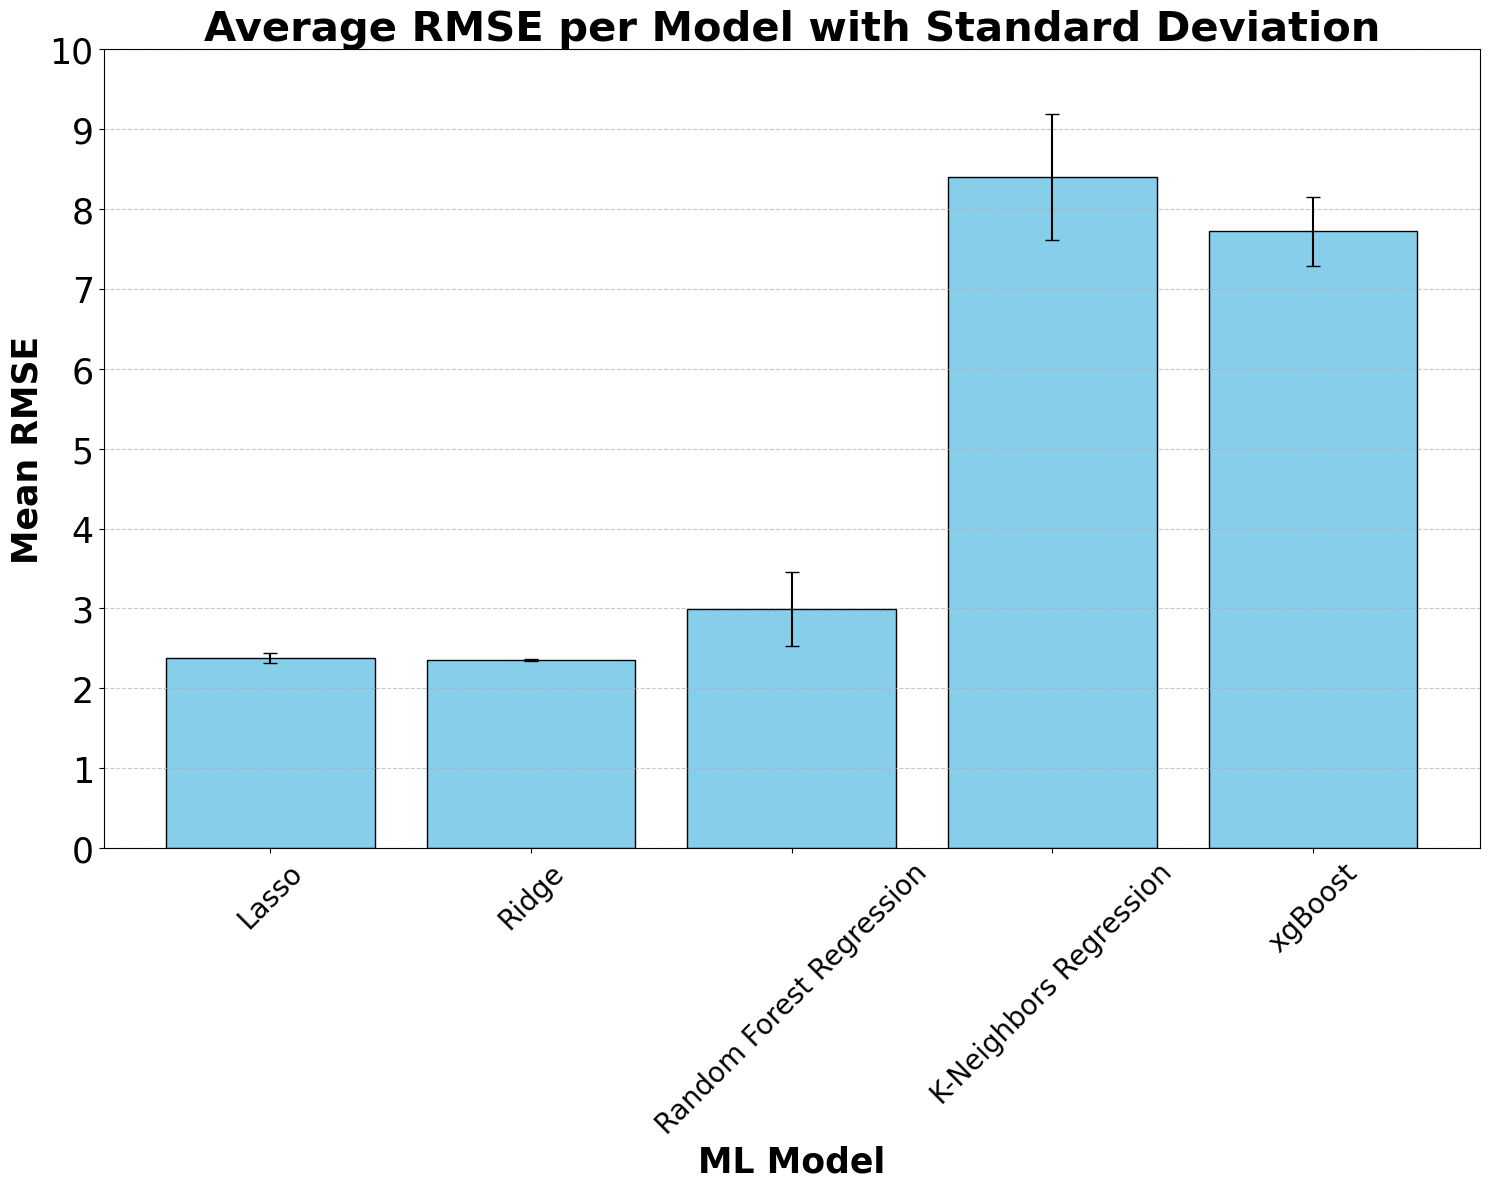

In [116]:
#Plotting the mean RMSE and standard deviation of the average RMSE for each machine learning model 
#we tried

#collect mean RMSE and its standard deviation for each model
mean_rmse = [mean_score_lasso, mean_score_ridge, mean_score_forest, mean_score_KNR, mean_score_xgb] 
std_dev = [standard_deviation_lasso, standard_deviation_ridge, standard_deviation_forest, standard_deviation_KNR, std_deviation_xgb]

#Plot figure, which will show the mean RMSE and its standard deviation as error plots. 
plt.figure(figsize=(15, 12)) 
plt.bar(model_names, mean_rmse, yerr=std_dev, capsize=5, color='skyblue', edgecolor='black')
plt.xlabel('ML Model', weight='bold', size=25)
plt.ylabel('Mean RMSE', weight='bold',size=25)
plt.xticks(rotation=45,size=20)
plt.yticks(np.arange(0, 11), size=25)
plt.ylim(0, 10)
plt.title('Average RMSE per Model with Standard Deviation', weight='bold', size=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#Save figure
plt.savefig('/Users/stefano/Desktop/DATA1030/FinalProject/Figures/AverageRMSEPlot.png', dpi=300)
plt.show()

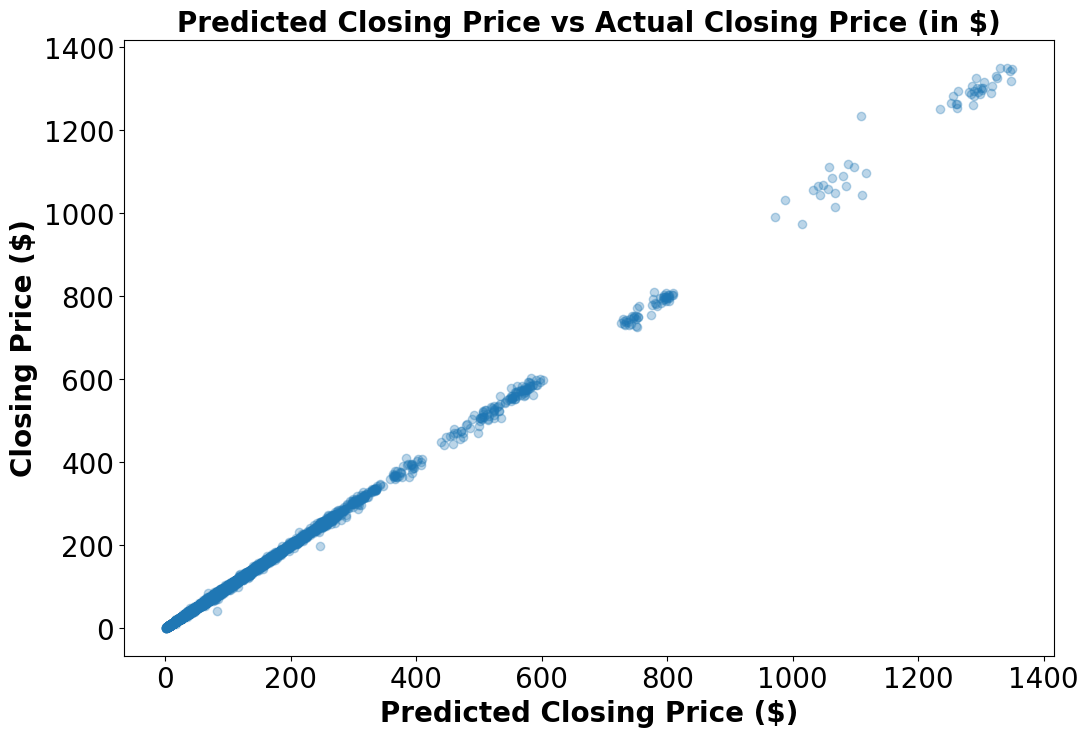

In [117]:
#Creating a graph to show the Ridge Model with its tuned hyperparameters' prediction of the closing price
#and the actual closing price of the stock. 

# Predicting our y_test values using the best model, for Ridge.
y_pred = best_models_ridge.predict(X_test)

#Save the predictions
y_test.to_csv('/Users/stefano/Desktop/DATA1030/FinalProject/Data/y_pred_ridge.csv',sep=',')

# Plotting the scatter plot of predicted vs the true y_test values
plt.figure(figsize=(12, 8))
plt.scatter(y_pred, y_test, alpha=0.3)
plt.title("Predicted Closing Price vs Actual Closing Price (in $)", weight='bold', size=20)
plt.xlabel("Predicted Closing Price ($)", weight='bold',size=20)
plt.ylabel("Closing Price ($)", weight='bold', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
#Save the figure
plt.savefig('/Users/stefano/Desktop/DATA1030/FinalProject/Figures/RidgePredictions.png', dpi=300)
plt.show()

In [118]:
#Calculating global importance using xgBoost and creating a graph showing the most important 5 features 
#according to this model .

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


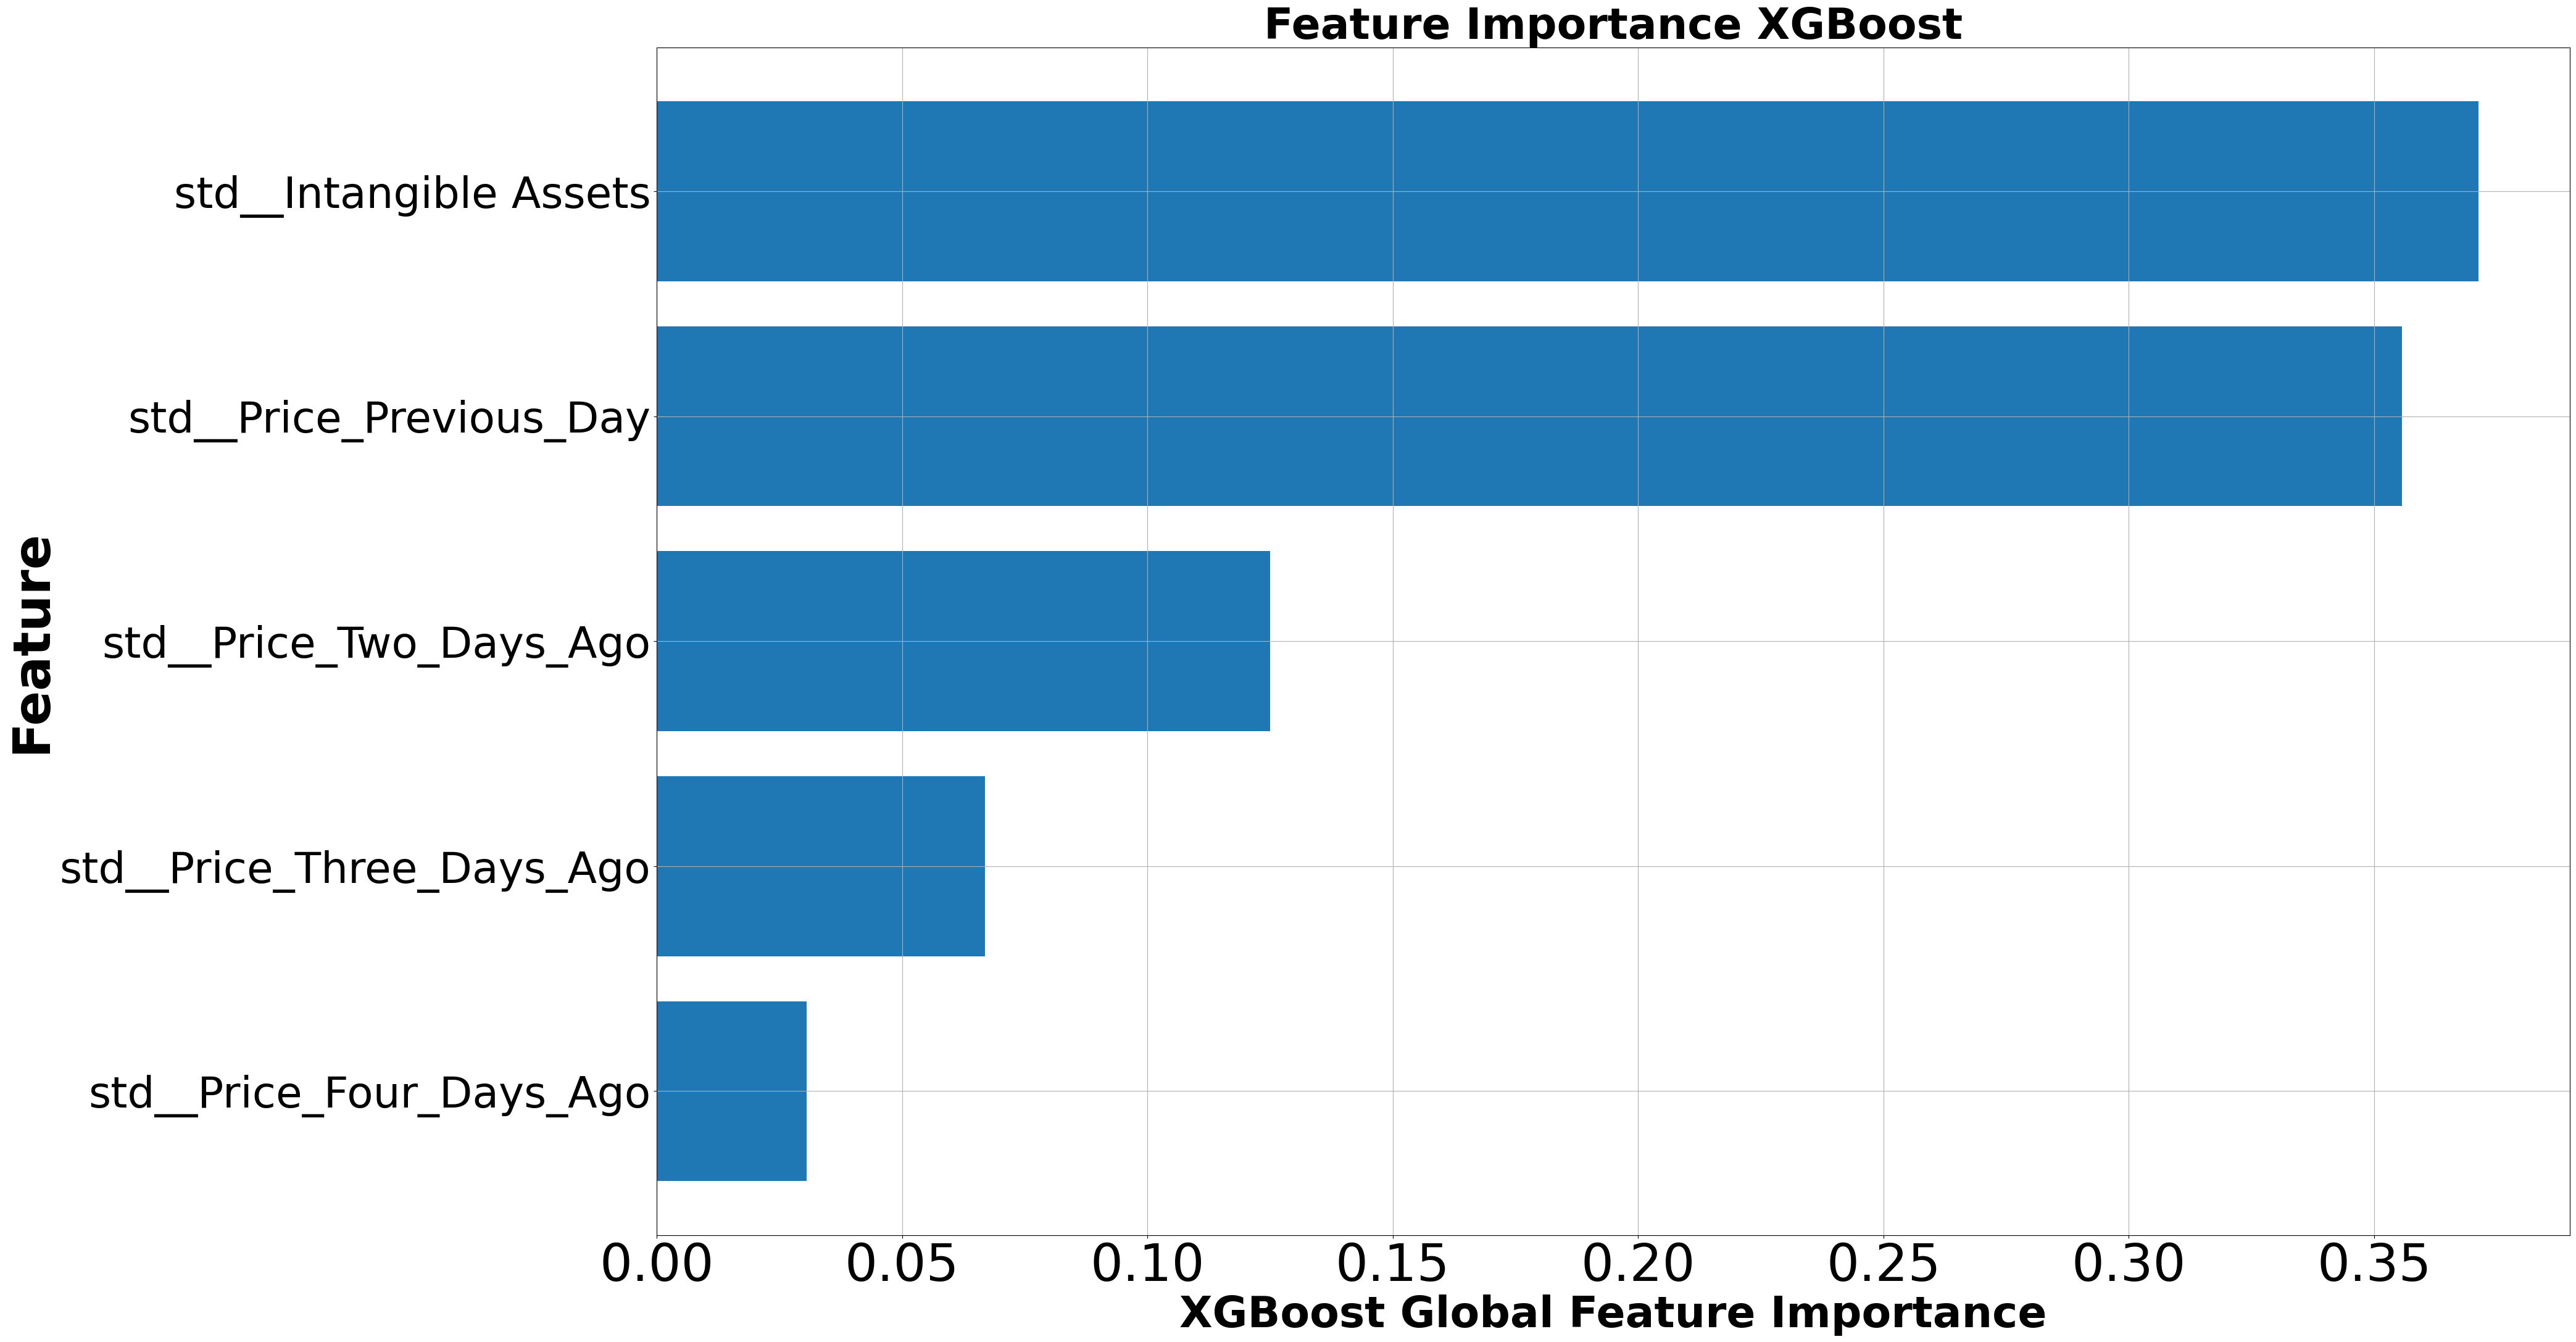

In [119]:
#Create a temporary x and y for this graph plotting
y_temporary = df['close']
X_temporary = df.drop(columns=['close'])

#Identify categorical and standard features 
cat_ftrs = ['GICS Sector'] 
std_ftrs = X_temporary.columns.drop(['GICS Sector', 'Date', 'Company']) 

preprocessor_final = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_ftrs),
        ('std', StandardScaler(), std_ftrs)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor_final),
                           ('model', xgb.XGBRegressor())])

#process the data using xgBoost
pipeline.fit(X_temporary, y_temporary)

#specify the model
model = pipeline.named_steps['model']

#find the names of the features 
feature_names = preprocessor_final.get_feature_names_out()

#find the importance of the features
feature_importances = model.feature_importances_

#Use a sorted index to find the top 5 features and their respective importance
top_5_idx = np.argsort(feature_importances)[-5:][::-1]
top_5_importances = feature_importances[top_5_idx]
top_5_feature_names = [feature_names[i] for i in top_5_idx]

#plot the graph 
plt.figure(figsize=(40, 25))
bars = plt.barh(top_5_feature_names, top_5_importances)
plt.xlabel("XGBoost Global Feature Importance", weight='bold', size=50)
plt.ylabel("Feature", weight='bold', size=60)
plt.xticks(size=60)
plt.yticks(size=50)
plt.title("Feature Importance XGBoost", weight='bold', size=50)
plt.gca().invert_yaxis()
#Save the figure
plt.savefig('/Users/stefano/Desktop/DATA1030/FinalProject/Figures/XGBoostImportance.png', dpi=300)
plt.grid()

In [ ]:
#This graph shows us how, rather unexpectadly, one of the most important global features for our xgBoost model
#is Intangibleble Assets, with the Price the Previous Day being close second. 

In [120]:
#Calculating global feature importance through permutation. 

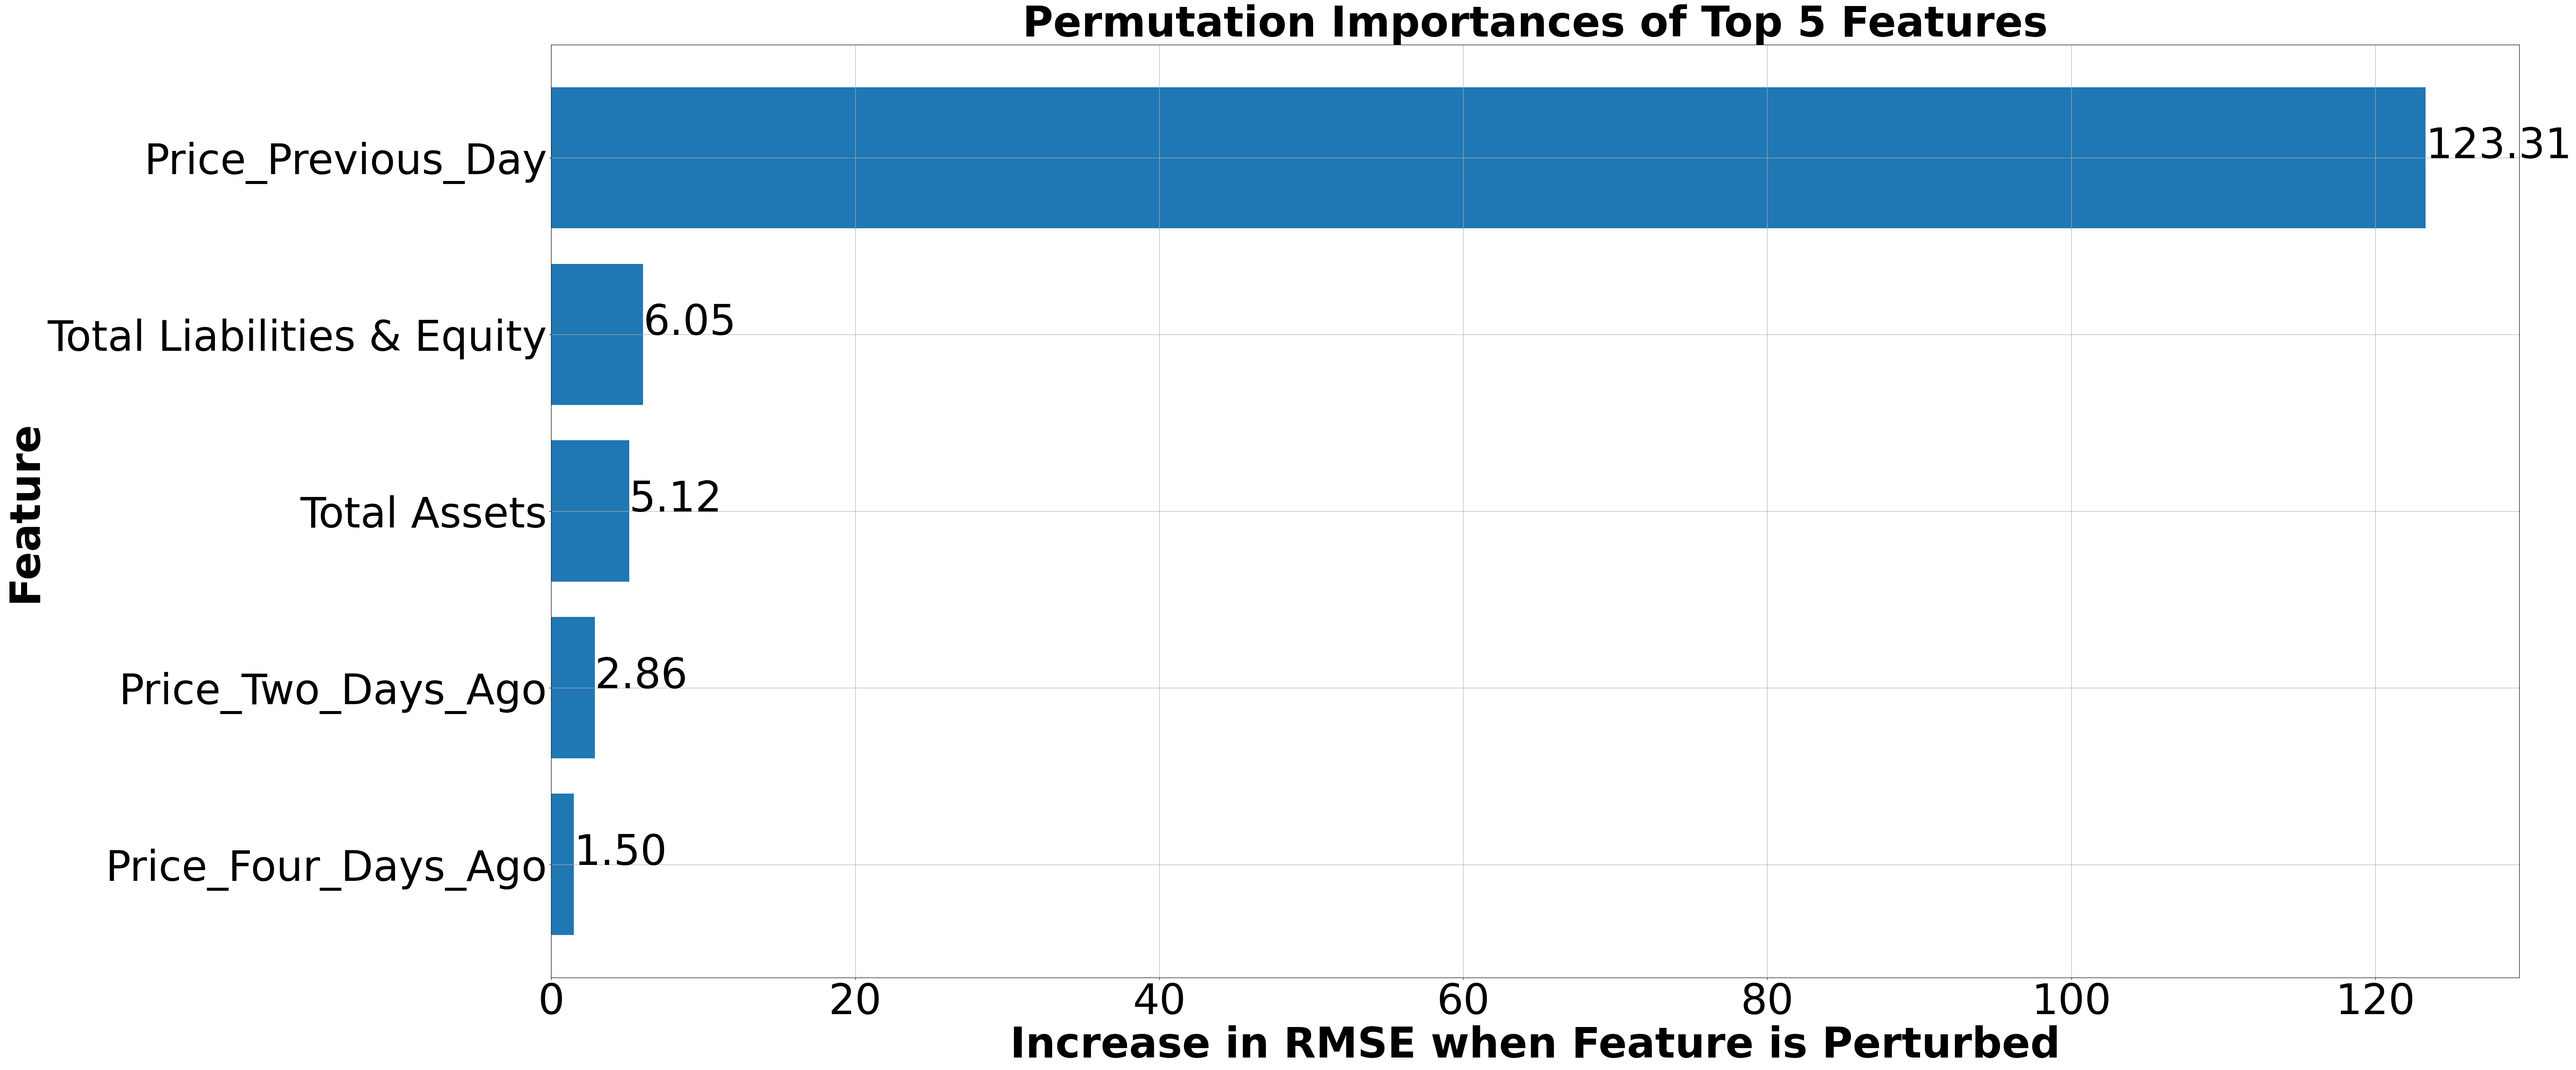

In [121]:
y= df[['close','Company', 'Date']]

X=df.drop(columns=['close'])

#Used to retrieve X_test and y_test
X_other, y_other, X_test, y_test= generate_splits(X,y)

#find permutation importance of the features
ftr_importance = permutation_importance(best_models_ridge, X_test, y_test, 
                                        scoring='neg_root_mean_squared_error',
                                        n_repeats=10, random_state=42)

#find the importance of the features
importances = ftr_importance.importances

#find the names of the features 
feature_names = X.columns

#Use a sorted index to find the top 5 features and their respective permutation importance

ascend_ind = np.argsort(np.mean(importances, axis=1))[::-1]
top_5_importances = np.mean(importances, axis=1)[ascend_ind][:5]
top_5_features = feature_names[ascend_ind][:5]

#Plot a bar graph showing the top 5 features by permutation importance
plt.figure(figsize=(60, 25))
bars = plt.barh(top_5_features, top_5_importances)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.2f}', fontsize=70)

plt.gca().invert_yaxis() 
plt.title("Permutation Importances of Top 5 Features",weight='bold',size=70)
plt.xlabel('Increase in RMSE when Feature is Perturbed',weight='bold',size=70)
plt.ylabel('Feature',weight='bold',size=70)
plt.xticks(size=70)
plt.yticks(size=70)
plt.grid()
plt.tight_layout()
#Save the figure
plt.savefig('/Users/stefano/Desktop/DATA1030/FinalProject/Figures/PermutationFeatures.png', dpi=300)
plt.show()

In [122]:
#The price of the previous day seems to be the most important freature when using permutaion to 
#classify feature importance. The reason previous prices aren't more influential could be 
#because if one is permutated info from the otehr days would be able to "offset" this permuation. 

In [123]:
#Create graph to show top 5 features by global importance calculated through Shap.

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
[15:38:44] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


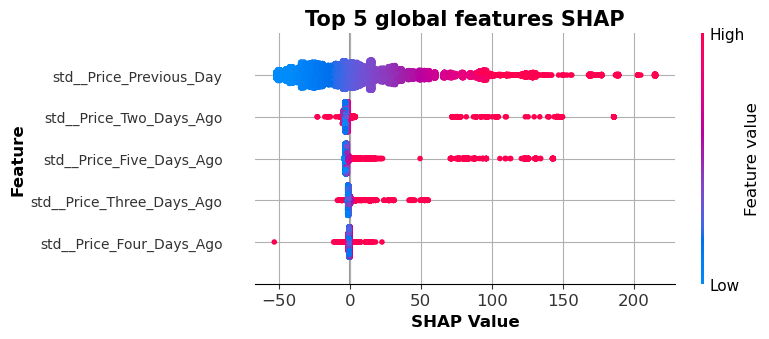

In [124]:
#Find X_test and y_test as well as X_other and y_other
X_other, y_other, X_test_unprocessed, y_test = generate_splits(X, y)

#Save the predefined splits to use to split our X_other and y_other into X_val and y_val

all_ps = generate_val_train_splits(X_other)

train_size, predefined_split = all_ps[0]

#Find the indices of the points in X_other that go to the training set

train_indices = [i for i, split_code in enumerate(predefined_split.test_fold) if split_code == -1]

#Create the X_train set from the X_other and process it
X_train_unprocessed = X_other.iloc[train_indices].drop(['Company', 'Date'], axis=1)
X_train = preprocessor_final.fit_transform(X_train_unprocessed)

#Get the column names out to later use in the graph
column_names = preprocessor_final.get_feature_names_out()

#Create the y_train set
y_train = y_other.iloc[train_indices].drop(['Company', 'Date'], axis=1)

#Transform the X_test set.
X_test= preprocessor_final.transform(X_test_unprocessed)

#Get the XGBRegressor model    
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

#specifying the Explainer model
explainer = shap.TreeExplainer(model)

#find the shap values of the features by using the shap_value command on X_test
shap_values = explainer.shap_values(X_test)

#plot the results to show top 5 global importance features accordingt to SHAP
plt.figure(figsize=(20,15)) 

shap.summary_plot(shap_values, X_test, 
                  max_display=5, feature_names=column_names, 
                  plot_type='dot', show=False, color='coolwarm')

plt.title("Top 5 global features SHAP",weight='bold',size=15)
plt.xlabel("SHAP Value",weight='bold',size=12)
plt.ylabel("Feature",weight='bold',size=12)
plt.xticks(size=12)
plt.yticks(size=10)
plt.grid()
plt.tight_layout()
#Save the figure
plt.savefig('/Users/stefano/Desktop/DATA1030/FinalProject/Figures/SHAPFeatures.png', dpi=300)
plt.show()

In [ ]:
#Again, the price the previous day seems to be the most important global feature when predicting our closing 
#stock price. This time, the other important global features are also the time lagged stock price. 

In [125]:
#Function to retrieve Date and Company name of a point in the test set. 

In [126]:
def find_details_i(X_matrix, index):
    X_test_reference_list=[]
    
    #group by company
    for company in X['Company'].unique():
        
        #Rearrange each ciompany's information by date
        company_data_X = X[X['Company'] == company].sort_values(by='Date')
        
        #carry out split to find the X_test we have in generate_splits
        max_index = len(company_data_X)
        test_length = round(max_index * 0.2)
        test_start = max_index - test_length
        
        #For each point (identified by the index) return Company and Date information
        X_test_reference = company_data_X.iloc[test_start:][['Company', 'Date']]
        X_test_reference_list.append(X_test_reference)
        
    #Add the X_test portion of each company's data to the X_test that will contain all the companies. 
    X_test_combined = pd.concat(X_test_reference_list, ignore_index=True)
    
    #After creating the test set find the information about the Date and Company by using the index
    information_on_point=X_test_combined.iloc[index]
    
    #Return this information    
    return information_on_point

In [127]:
#Now we calculate the local feature importance of three different stocks using shap. 
#I then show the date and ticker name of the selected stock. 

In [128]:
#Necessary to display later visualisations
shap.initjs()

In [129]:
#Choosing a random point in the X_test set to show the local importance of certain features to it.
point_1=440
shap.force_plot(explainer.expected_value, shap_values[point_1], feature_names = column_names,show=True)

In [130]:
#Displaying the Company and Date information for the point

first_point_info= find_details_i(X,point_1)
print("Information regarding first point:", first_point_info)

Information regarding first point: Company           ADS
Date       2016-02-18
Name: 440, dtype: object


In [131]:
#Choosing a random point in the X_test set to show the local importance of certain features to it.
point_2=1000
shap.force_plot(explainer.expected_value, shap_values[point_2], feature_names = column_names,show=True)

In [132]:
#Displaying the Company and Date information for the point
second_point_info= find_details_i(X,point_2)
print("Information regarding second point:", second_point_info)

Information regarding second point: Company           ALL
Date       2016-02-09
Name: 1000, dtype: object


In [133]:
#Choosing a random point in the X_test set to show the local importance of certain features to it.
point_3=7500
shap.force_plot(explainer.expected_value, shap_values[point_3], feature_names = column_names,show=True)

In [134]:
#Displaying the Company and Date information for the point
third_point_info= find_details_i(X,point_3)
print("Information regarding second point:", third_point_info)

Information regarding second point: Company           FLS
Date       2016-03-24
Name: 7500, dtype: object
